In [ ]:
%reset

import matplotlib.pyplot as plt
from sklearn import linear_model
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import statsmodels.api as sma
from matplotlib import cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator
from matplotlib.gridspec import GridSpec
import pylab
from PIL import Image, ImageDraw
from scipy import signal
import warnings
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import datetime
import time
import glob
import numpy as np
import math
import os

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
## Carregar aqui para os estudos do artigo...

warnings.filterwarnings('ignore')
path = 'G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Analises_GEE/Avaliacao_Areas_geometry/'
#G:/
n_area = [i+1 for i in range(29)]

#n_area.remove(17)
#n_area.remove(6)

result = pd.DataFrame()
#Note: The order of the downloaded areas in the script is not the same as in the manuscript. To match the manuscript's order, use the following mapping:

k_dict = {1: 16, 2: 15, 3: 18, 4: 17, 5: 19, 6: 20, 7: 21, 8: 22, 9: 23, 10: 24,
          11: 25, 12: 26, 13: 27, 14: 28, 15: 29, 16: 11, 17: 10, 18: 12, 19: 13,
          20: 14, 21: 6, 22: 7, 23: 8, 24: 9, 25: 3, 26: 4, 27: 5, 28: 2, 29: 1}


for narea in n_area:

    k = k_dict.get(narea, narea)

    #print(k)
    #print(narea)
    areadir = 'Area'+ str(narea)

    tmpDry = pd.read_csv(path + "/" + areadir + "/Total_Area/yearly_average/" + areadir + "_Dry.csv")
    tmpDry.drop("Unnamed: 0",axis=1, inplace=True)
    tmpDry["maximum_2m_air_temperature"] =  tmpDry["maximum_2m_air_temperature"] - 273.15
    tmpDry["Percent"] = 100 - tmpDry["Percent"] #Deforestation Fraction
    tmpDry["Type"] = "Dry"
    tmpDry["Area"] = k
    #print(k)

    tmpWet = pd.read_csv(path + "/" + areadir + "/Total_Area/yearly_average/" + areadir + "_Wet.csv")
    tmpWet.drop("Unnamed: 0",axis=1, inplace=True)
    tmpWet["maximum_2m_air_temperature"] =  tmpWet["maximum_2m_air_temperature"] - 273.15
    tmpWet["Percent"] = 100 - tmpWet["Percent"] #Deforestation Fraction
    tmpWet["Type"] = "Wet"
    tmpWet["Area"] = k

    tmpTotal = pd.read_csv(path + "/" + areadir + "/Total_Area/yearly_average/" + areadir + "_Total.csv")
    tmpTotal.drop("Unnamed: 0",axis=1, inplace=True)
    tmpTotal["maximum_2m_air_temperature"] =  tmpTotal["maximum_2m_air_temperature"] - 273.15
    tmpTotal["Percent"] = 100 - tmpTotal["Percent"] #Deforestation Fraction
    tmpTotal["Type"] = "Total"
    tmpTotal["Area"] = k

    # Append the data of each iteration to the main dataframe
    result = result.append([tmpDry, tmpWet, tmpTotal], ignore_index=True)


k = result[result['date'] == 2020]
k = k[k['Type']=='Dry']
#k = k['Percent']
#np.mean(k)
k = k.sort_values(by='Area')
#len(k['Area'])
#k


In [ ]:
for year in range(1985, 2021):
    k = result[(result['date'] == year) & (result['Type'] == 'Dry')]
    k = k.sort_values(by='Area')
    length_of_area_column = len(k['Area'])

-0.021114865335235364 0.11039703087820768
R = 0.97
p-value = 0.01
R = 0.54
p-value = 0.0
-0.008570219220118247 17.806214562231247


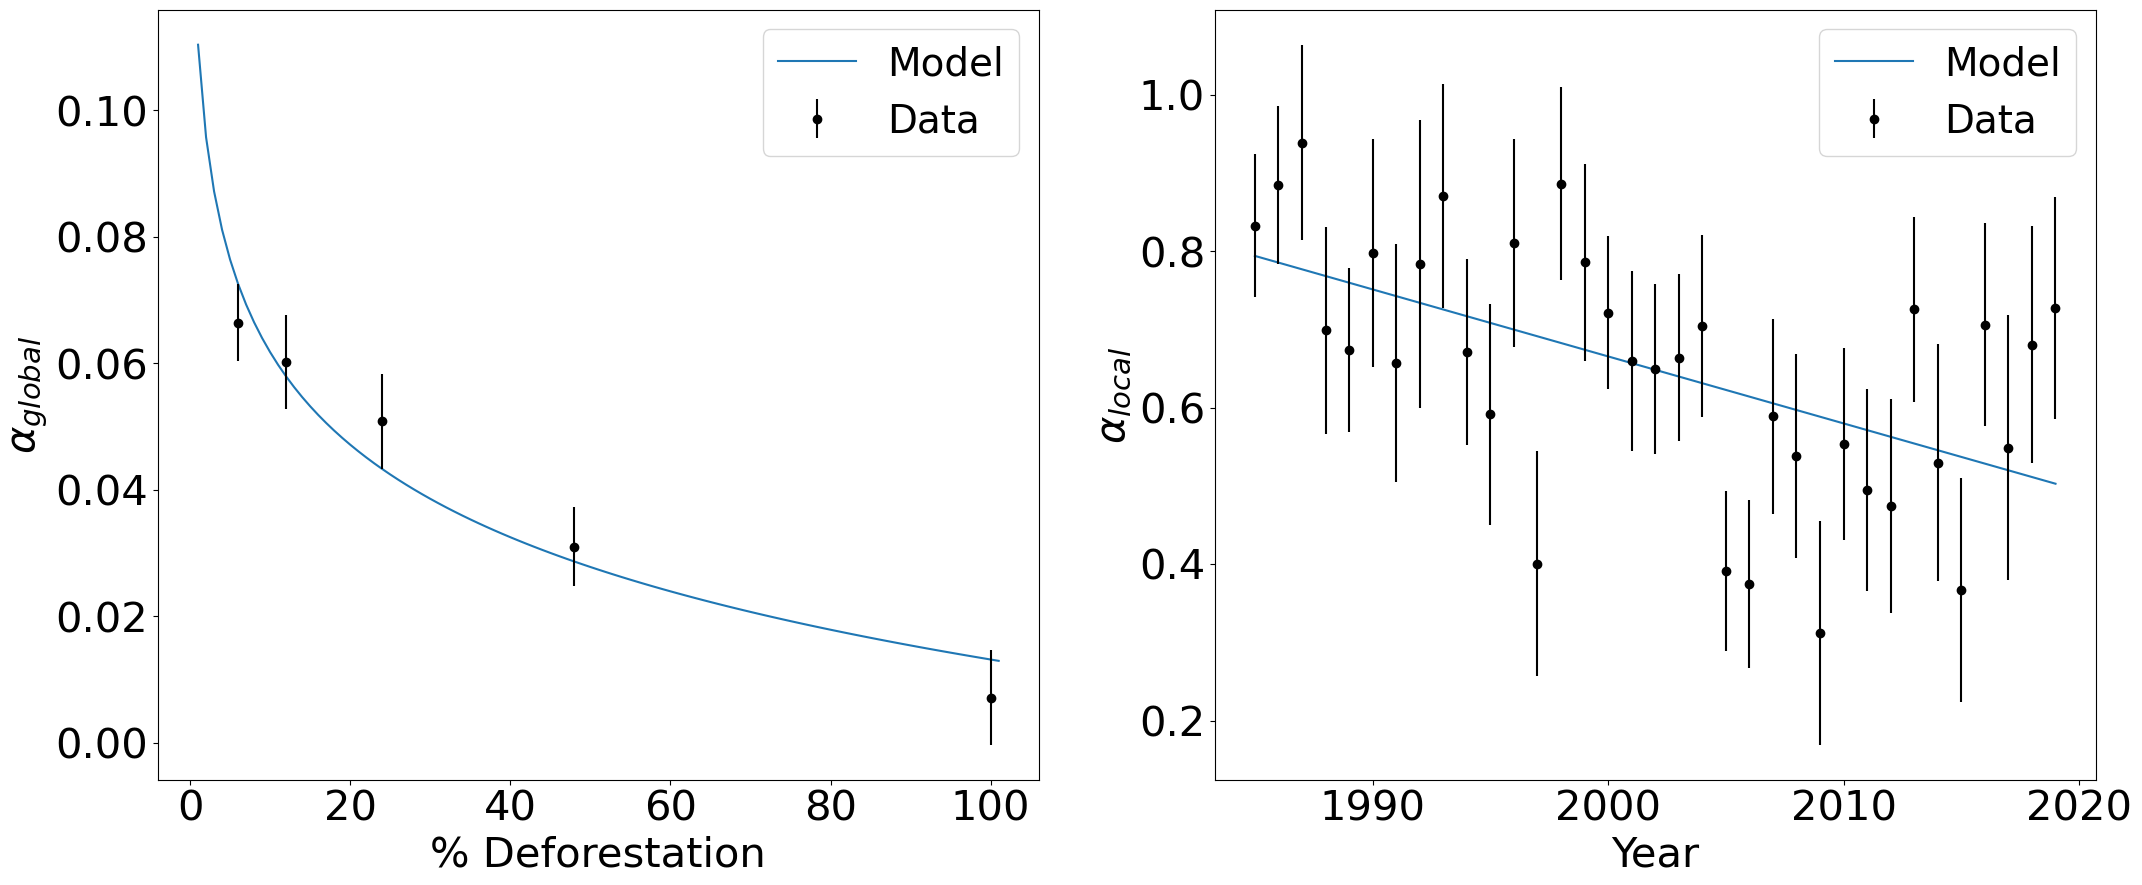

In [ ]:
var = 'maximum_2m_air_temperature' #'maximum_2m_air_temperature' porcentagem precip_mm_month
#Periods: precipitation - 2000 to 2020; max temp: 1985 - 2020; CO2 - 2015 - 2020; CH4: 2003 - 2020

a = 1985
b = 2020

df_notnull_dry = result[result['Type'] == 'Dry']  ### Mudar quando necessario para dry
df_notnull_dry = df_notnull_dry[df_notnull_dry[var].notnull()]

dfs = []
percent_uppers = []
#for i in range(1, 5):
#    percent_lower = (i - 1) * 20
#    percent_upper = i * 20
#    query_str = f'Percent >= {percent_lower} & Percent < {percent_upper}'
#    df = df_notnull_dry.query(query_str)
#    dfs.append(df)
#    percent_uppers.append(percent_upper)

percent_lower = [0, 3 ,6, 12, 24, 48]
percent_upper = [3 ,6, 12, 24, 48, 100]

for i in range(1, 6):

    query_str = f'Percent >= {percent_lower[i]} & Percent < {percent_upper[i]}'
    #print(query_str)
    df = df_notnull_dry.query(query_str)
    dfs.append(df)
    percent_uppers.append(percent_upper[i])

def func(x, a, b):
    return a * x + b

coefficients = []
pearson_correlation = []
p_values = []
incert = []
for i, df in enumerate(dfs):
    x = df['date'].values
    y = df[var].values

    #print(percent_uppers[i])
    if len(x) == 0 or len(y) == 0:
        continue  # Pula o loop quando o vetor for vazio

    popt, pcov = curve_fit(func, x, y, p0=[1, 1])
    coefficients.append(popt)

    popt_err = np.sqrt(np.diag(pcov))
    incert.append(popt_err)

    r, p = pearsonr(x, y)
    pearson_correlation.append(r)
    p_values.append(p)

    #if abs(r) > 0 and p < 10.05:
        #plt.scatter(df['date'], df[var], c=df['Percent'])
        #plt.title(f"Pearson: {r:.2f}, p-value: {p:.2f}, ang.: {popt[0]}")
        #plt.show()

perc = []
cfs = []
erro = []
for i, coeff in enumerate(coefficients):
    r = pearson_correlation[i]
    p = p_values[i]
    tmperr =  incert[i]

    if abs(r) > 0 and p < 100.05:
        perc.append(percent_uppers[i])
        cfs.append(coeff[0])
        erro.append(tmperr[0])


def func(x, a, b):
    return a * np.log((x)) + b

popt, pcov = curve_fit(func, perc, cfs,p0=[1, 1])
xx = range(1,102)
yfit = func(xx, *popt)
yf = func(np.array(perc),*popt)

print(*popt)

r, p = pearsonr(cfs, yf)
print('R = ' + str(round(r,2)))
print('p-value = ' + str(round(p,2)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
plt.rcParams.update({'font.size': 28})
ax = axes[0]

ax.plot(xx, yfit, label = 'Model')
ax.errorbar(perc, cfs, yerr=erro, color="black", marker='o', linestyle='', label='Data')
ax.set_xlabel ('% Deforestation')
ax.set_ylabel(r'$\alpha_{global}$')
ax.legend()

def func(x, a, b):
    return a *np.log((x))  + b

coefficients = []  # Armazena os coeficientes angulares
aerr = []

for year in range(a, b):
    df_notnull_dry = result[(result['Type'] == 'Dry') & (result['date'] == year)] ######## Mudar para Dry
    df_notnull_dry = df_notnull_dry[df_notnull_dry[var].notnull()]

    x = df_notnull_dry['Percent'].values
    y = df_notnull_dry[var].values

    popt, pcov = curve_fit(func, x, y, p0=[1, 1])
    coefficients.append(popt[0])

    a_err, b_err = np.sqrt(np.diag(pcov))
    aerr.append(a_err)

    x2 = np.arange(0, 101, 1)
    ypred = func(x2, *popt)

    ypred2 = func(x, *popt)
    r, p = pearsonr(y, ypred2)

def func(x, a, b):
    return a * x + b #np.log((x))

popt, pcov = curve_fit(func, range(a, b), coefficients,p0=[1, 1])

xx = range(a,b)

yf = func(np.array(range(a, b)),*popt)

r, p = pearsonr(coefficients, yf)
print('R = ' + str(round(r,2)))
print('p-value = ' + str(round(p,2)))

print(*popt)

#print(coefficients)

ax = axes[1]
ax.plot(xx, yf, label = 'Model')
ax.errorbar(range(a, b), coefficients, yerr = aerr, color = "black", marker='o', linestyle='', label = 'Data')
ax.set_xlabel('Year')
ax.set_ylabel(r'$\alpha_{local}$')
ax.legend()
plt.show()
#print(np.mean(coefficients))

-0.009730887347082806 20.13146539721973 0.07144871412511568 -112.55960409331983


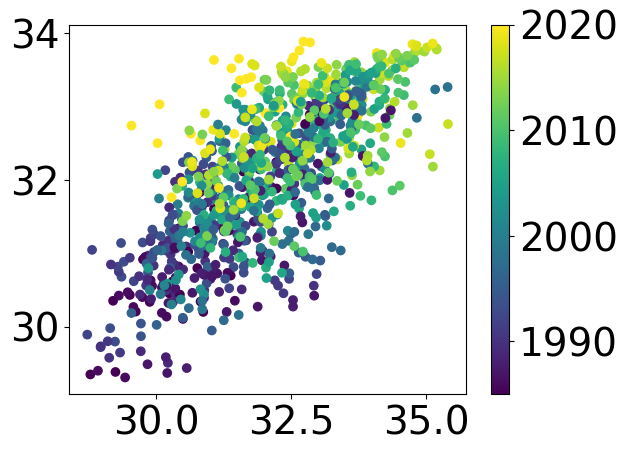

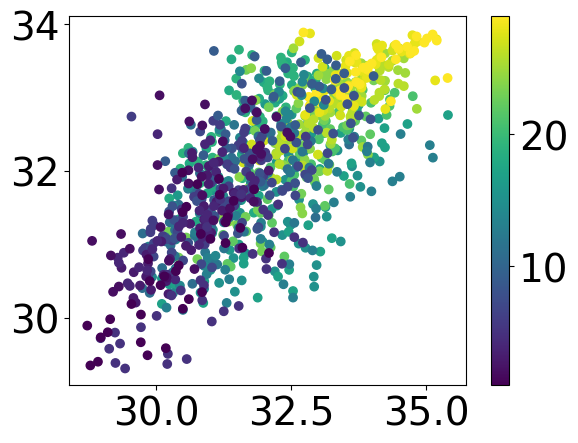

Pearson correlation coefficient =  0.74
p-value =  5.3530386679766894e-166


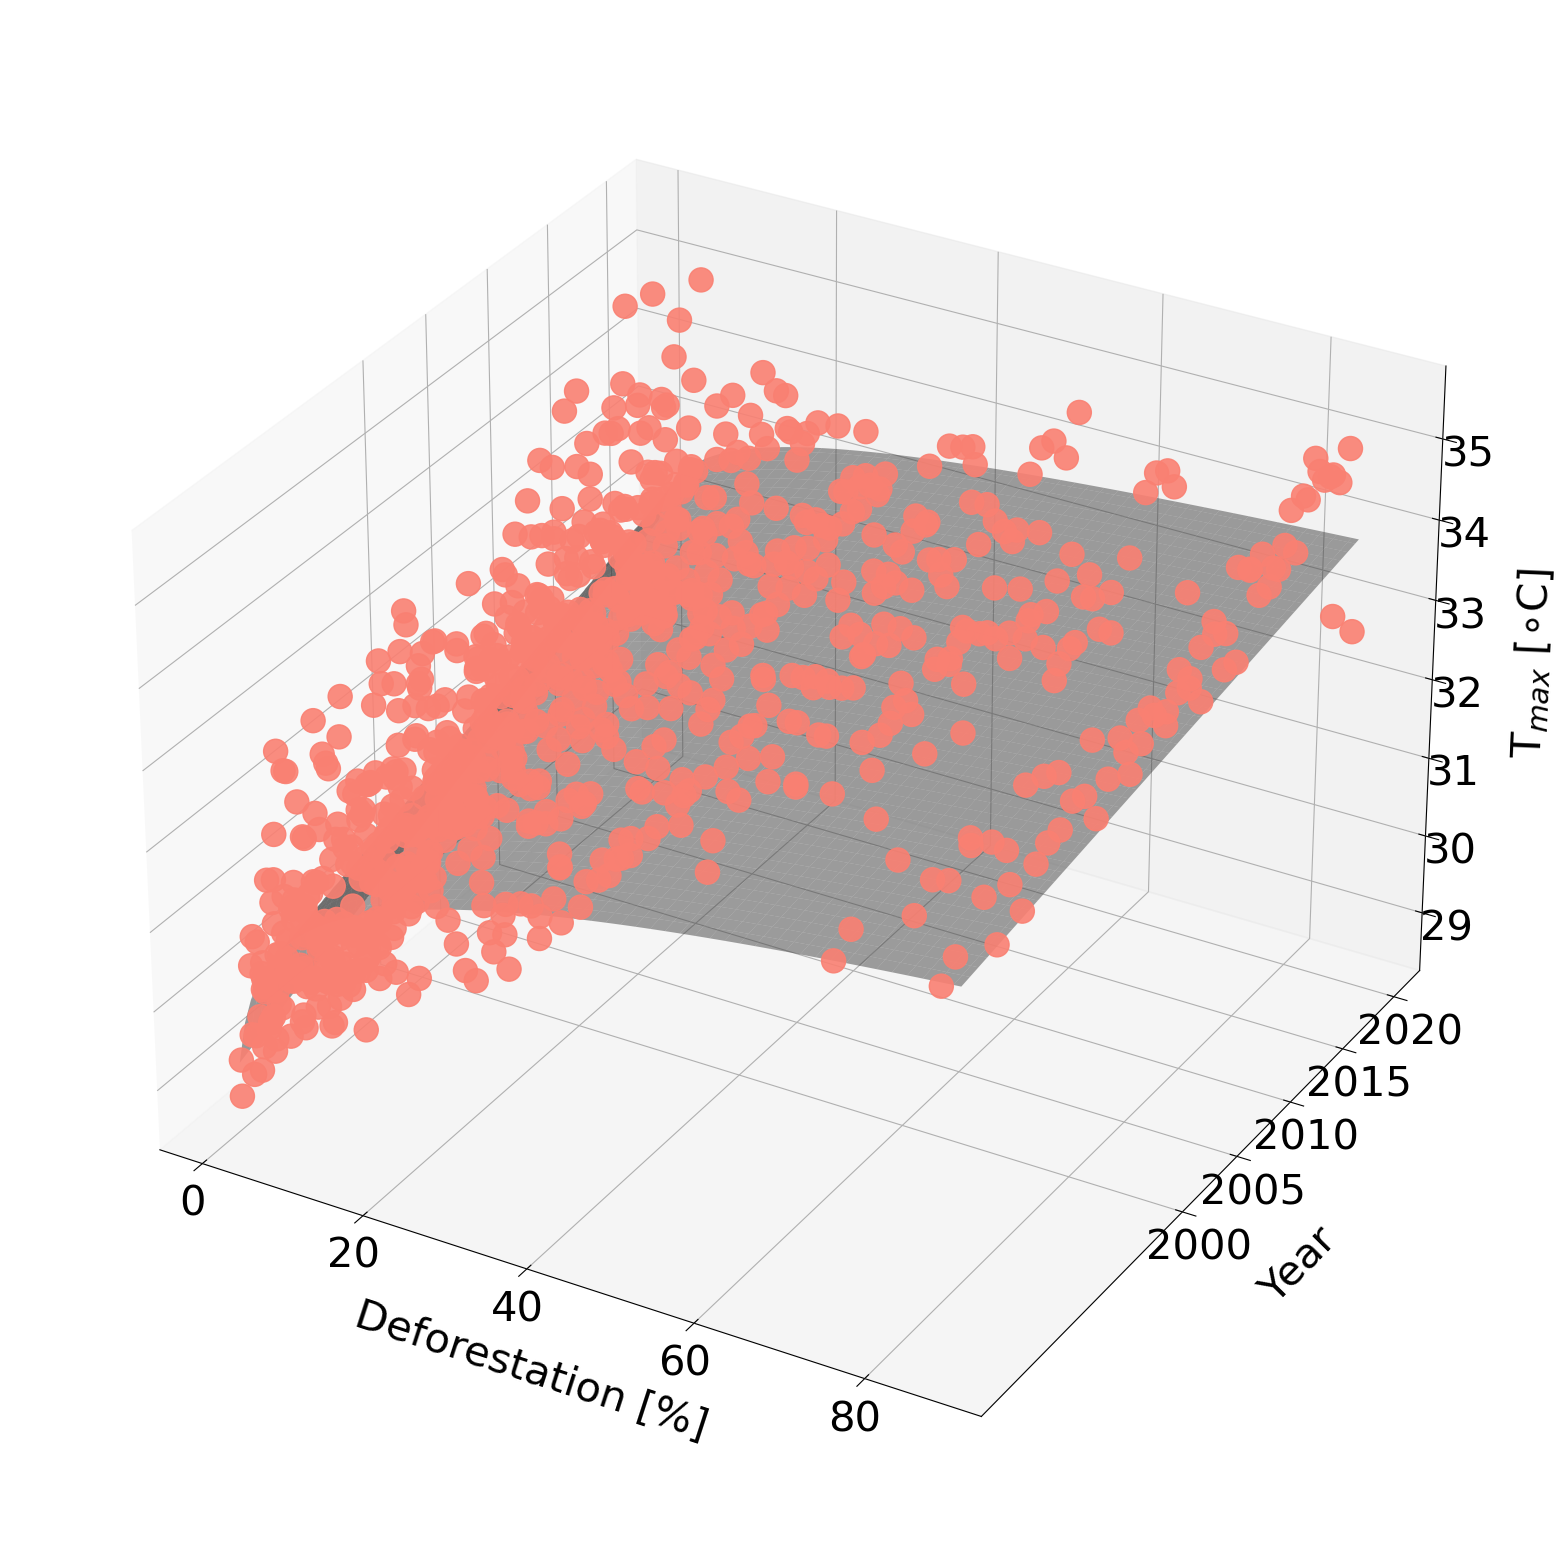

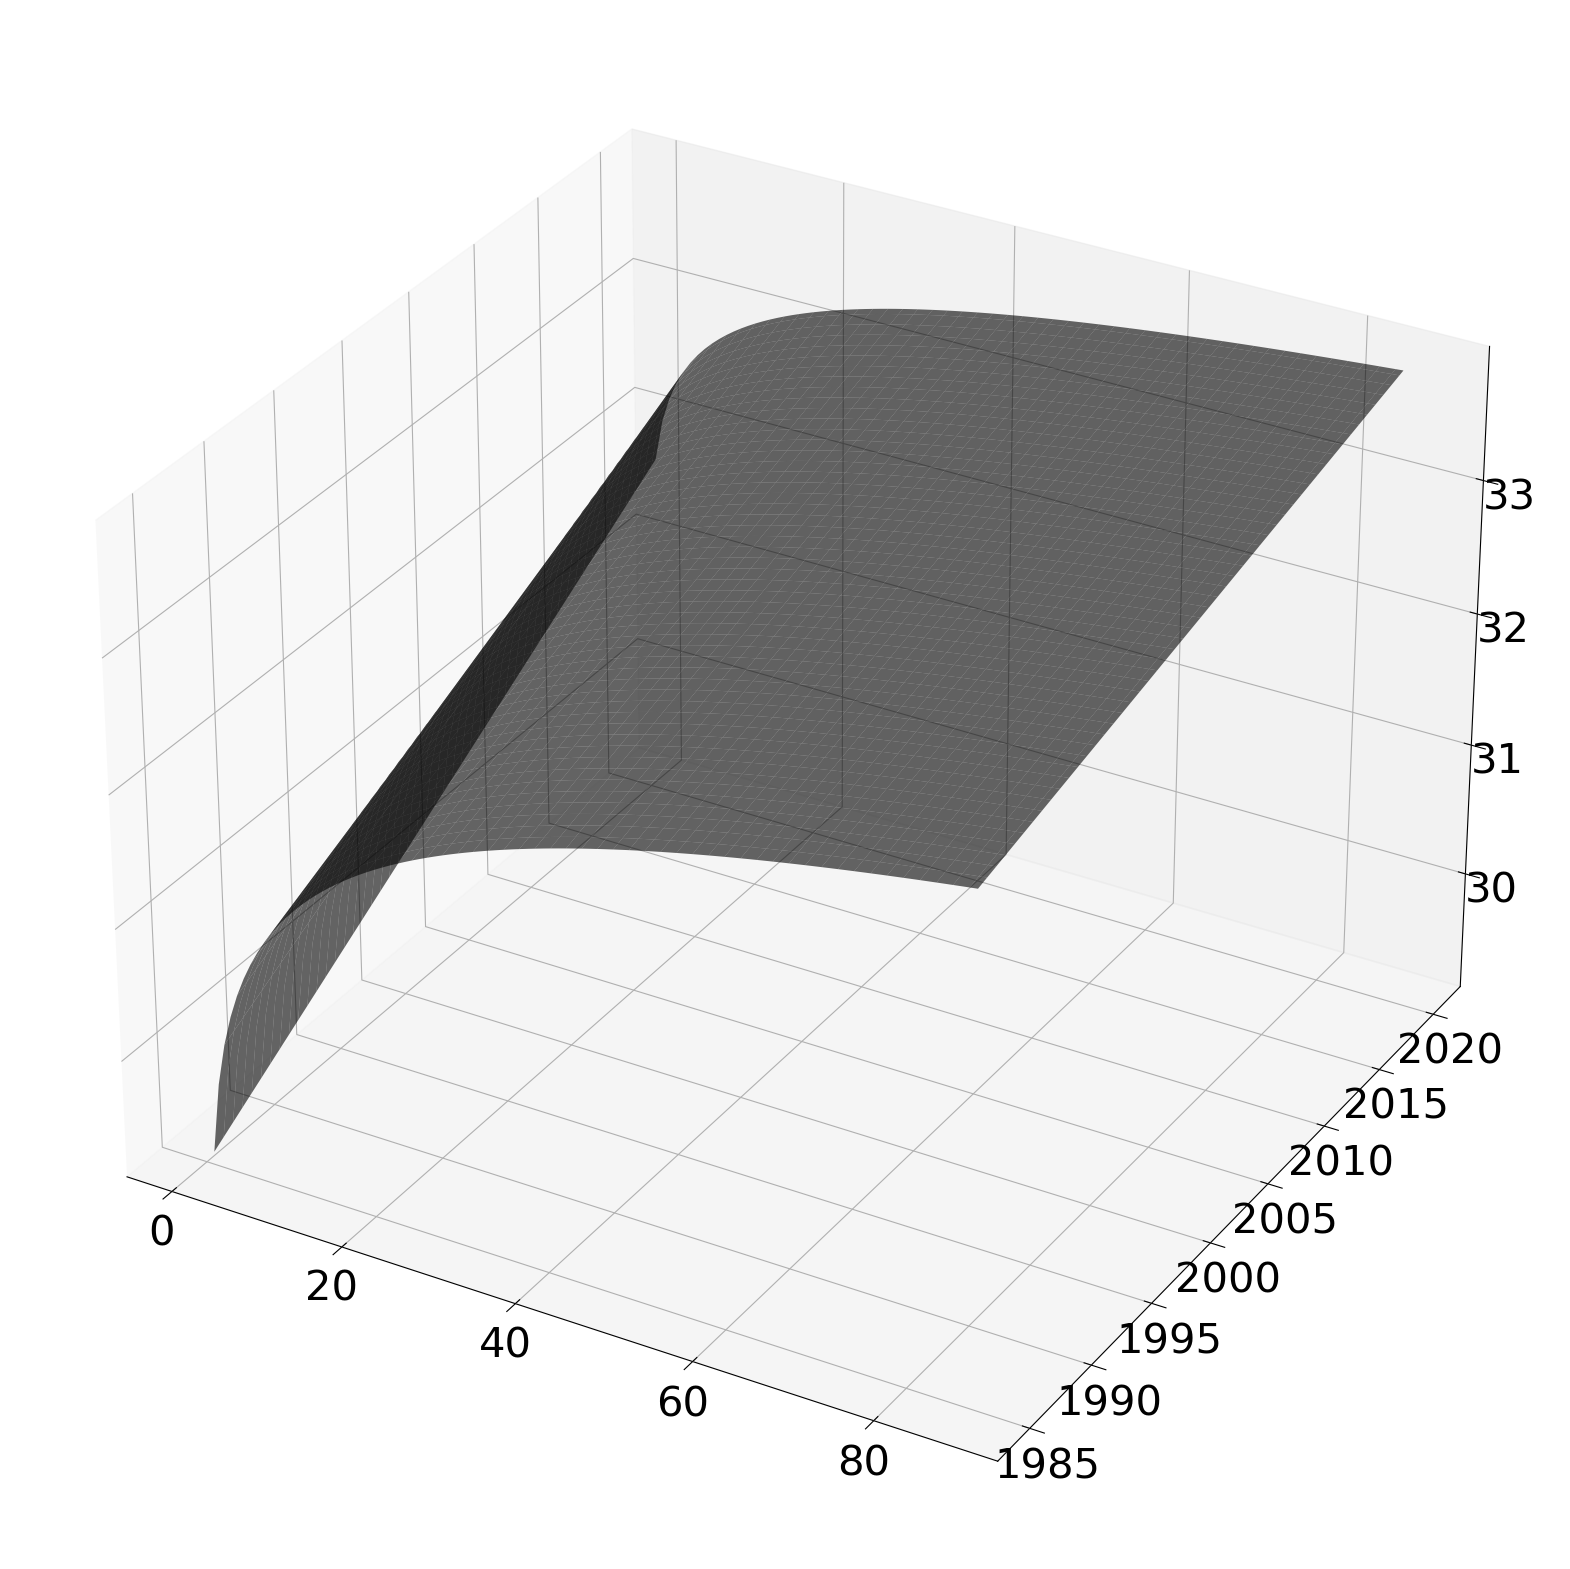

In [ ]:
#Casos "diferentes"

def func(x, a, b, c, d):

    return np.log(x[:, 1]) * (a * x[:, 0] + b) + c *  x[:, 0] + d

df_notnull = []
df_notnull = result[result['Type'] == 'Dry']
df_notnull = df_notnull[df_notnull['date'] >= a]
df_notnull = df_notnull[result[var].notnull()]

x = df_notnull[["date", "Percent"]].values
y = df_notnull[var]

# Set initial guesses for the parameters
a0 = 1
b0 = 1
c0 = 1
d0 = 1
e0 = 1

# Perform the curve fit
popt, pcov = curve_fit(func, x, y, p0=[a0, b0, c0, d0])

# Calculate the predicted values using the fitted function
y_pred = func(x, *popt)

print(*popt)

# Calculate the Pearson correlation coefficient between predicted and observed values
corr, pval = pearsonr(y, y_pred)

#plt.plot(x,y)
sc = plt.scatter(y,y_pred, c=df_notnull["date"])
plt.colorbar(sc)
plt.show()

sc2 = plt.scatter(y,y_pred, c=df_notnull["Area"])
plt.colorbar(sc2)
plt.show()

print("Pearson correlation coefficient = ", round(corr,2))
print("p-value = ", pval)

# Generate data for the fitted curve
xfit = np.linspace(x[:, 0].min(), x[:, 0].max(), 100)
yfit = np.linspace(x[:, 1].min(), x[:, 1].max(), 100)
xfit, yfit = np.meshgrid(xfit, yfit)
zfit = func(np.column_stack((xfit.ravel(), yfit.ravel())), *popt)
zfit = zfit.reshape(xfit.shape)

fig = plt.figure(figsize=(25, 20))
plt.rcParams.update({'font.size': 30})
ax = fig.add_subplot(111, projection="3d")
ax.set_box_aspect(aspect=None, zoom=0.95)
ax.scatter(x[:, 1], x[:, 0], y, color='salmon', s=300, alpha=0.9)
ax.plot_surface(yfit, xfit, zfit, color="grey", alpha=0.5)

# Set axis labels and a title
ax.set_xlabel("\n \n Deforestation [%]")
ax.set_ylabel("\n \n \n Year")
ax.set_zlabel(" \n \n T$_{max}$ [$\circ$C]")

years_ticks = np.arange(2000, 2022, 5)

# Defina os rótulos correspondentes
years_labels = [str(year) for year in years_ticks]

# Configure os rótulos no eixo "Year"
ax.set_yticks(years_ticks)
ax.set_yticklabels(years_labels)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(20, 25))

ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(yfit, xfit, zfit, color="black", alpha=0.6)
plt.show()



In [ ]:
filtered_result = result[result['date'] == 2020]

# Calcular a média dos percentuais para o ano de 2020
media_percent_2020 = filtered_result['Percent'].mean()
print("Média de Percent para 2020:", media_percent_2020)


filtered_result = result[result['date'] == 1985]

# Calcular a média dos percentuais para o ano de 2020
media_percent_1985 = filtered_result['Percent'].mean()
print("Média de Percent para 1985:", media_percent_1985)

Média de Percent para 2020: 27.09262038420981
Média de Percent para 1985: 15.280535579403162


In [ ]:
###Integracoes
#print(popt)
#Contribuicao anual
totGlob = (popt[0]*np.log(21.19) + popt[2])*2020 - (popt[0]*np.log(21.19) + popt[2])*1985
#print(totGlob)

#Modelo
ymodel_2020 = np.log(28.900882471074993) * (popt[0]*2020 + popt[1]) + popt[2]*2020 + popt[3]
#print(ymodel_2020)

ymodel_X = np.log(32.4) * (popt[0]*2035 + popt[1]) + popt[2]*2035 + popt[3]
#print(ymodel_X)

deltaModel = ymodel_X - ymodel_2020

#print(deltaModel)

#print(totGlob/deltaModel)


In [ ]:
ymodel_1985 = np.log(15) * (popt[0]*1985 + popt[1]) + popt[2]*1985 + popt[3]
#print(ymodel_1985)

In [ ]:
#Contribuicao local
totLoc =  ((popt[0]*2002 + popt[1])*np.log(27.09262038420981) - (popt[0]*2002 + popt[1])*np.log(15.280535579403162) )
#print(totLoc)
#print(totLoc/deltaModel)

In [ ]:
warnings.filterwarnings('ignore')
path = 'G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Analises_GEE/Avaliacao_Areas_geometry/'
#G:/
n_area = [i+1 for i in range(29)]

result = pd.DataFrame()

k_dict = {1: 16, 2: 15, 3: 18, 4: 17, 5: 19, 6: 20, 7: 21, 8: 22, 9: 23, 10: 24,
          11: 25, 12: 26, 13: 27, 14: 28, 15: 29, 16: 11, 17: 10, 18: 12, 19: 13,
          20: 14, 21: 6, 22: 7, 23: 8, 24: 9, 25: 3, 26: 4, 27: 5, 28: 2, 29: 1}


for narea in n_area:

    k = k_dict.get(narea, narea)

    #print(k)
    #print(narea)
    areadir = 'Area'+ str(narea)

    tmpDry = pd.read_csv(path + "/" + areadir + "/Total_Area/yearly_average/" + areadir + "_Dry.csv")
    tmpDry.drop("Unnamed: 0",axis=1, inplace=True)
    tmpDry["maximum_2m_air_temperature"] =  tmpDry["maximum_2m_air_temperature"] - 273.15
    tmpDry["Percent"] = 100 - tmpDry["Percent"] #Deforestation Fraction
    tmpDry["Type"] = "Dry"
    tmpDry["Area"] = k
    #print(k)

    tmpWet = pd.read_csv(path + "/" + areadir + "/Total_Area/yearly_average/" + areadir + "_Wet.csv")
    tmpWet.drop("Unnamed: 0",axis=1, inplace=True)
    tmpWet["maximum_2m_air_temperature"] =  tmpWet["maximum_2m_air_temperature"] - 273.15
    tmpWet["Percent"] = 100 - tmpWet["Percent"] #Deforestation Fraction
    tmpWet["Type"] = "Wet"
    tmpWet["Area"] = k

    tmpTotal = pd.read_csv(path + "/" + areadir + "/Total_Area/yearly_average/" + areadir + "_Total.csv")
    tmpTotal.drop("Unnamed: 0",axis=1, inplace=True)
    tmpTotal["maximum_2m_air_temperature"] =  tmpTotal["maximum_2m_air_temperature"] - 273.15
    tmpTotal["Percent"] = 100 - tmpTotal["Percent"] #Deforestation Fraction
    tmpTotal["Type"] = "Total"
    tmpTotal["Area"] = k

    # Append the data of each iteration to the main dataframe
    result = result.append([tmpDry, tmpWet, tmpTotal], ignore_index=True)



In [ ]:
# Filtrar apenas as áreas que faltam (6 e 17)
result_missing = result
# Calcular a média da coluna 'Percent' para cada área em 1985 e 2020
result_filtered = result_missing[(result_missing['date'] == 1985) | (result_missing['date'] == 2020)]
# Calcular a média da coluna 'Percent' para cada área em 1985 e 2020
result_grouped = result_filtered.groupby(['Area', 'date'])['Percent'].mean().unstack()

# Imprimir os valores das médias em 1985 e 2020 para cada área
#print("Médias de Percent em 1985:")
#print(result_grouped[1985])
#print("\nMédias de Percent em 2020:")
#print(result_grouped[2020])
result_grouped['Media_1985_2020'] = result_grouped.mean(axis=1)
# Imprimir os valores das médias em 1985 e 2020, e a média entre 1985 e 2020 para cada área
print(result_grouped)

date       1985       2020  Media_1985_2020
Area                                       
1      1.103129   1.549964         1.326546
2      3.780660  14.272080         9.026370
3      3.155581   3.188661         3.172121
4      4.168782   4.683856         4.426319
5      1.150121   0.990851         1.070486
6      7.546291   7.762666         7.654479
7      5.039192   5.059121         5.049156
8      8.579730  19.943569        14.261650
9     17.532777  51.066550        34.299663
10    16.533103  20.897479        18.715291
11     3.711449   6.136084         4.923767
12     5.219200   6.119635         5.669417
13     2.792491   5.731580         4.262036
14     4.191406  28.492186        16.341796
15     3.731340   4.101555         3.916448
16     4.280416  11.102236         7.691326
17     3.137543  12.902275         8.019909
18    12.210470  40.152794        26.181632
19    22.315276  52.863944        37.589610
20    80.286602  83.316346        81.801474
21    20.852665  21.525380      

In [ ]:
totGlob = (popt[0]*np.log(result_grouped['Media_1985_2020']) + popt[2])*2020 - (popt[0]*np.log(result_grouped['Media_1985_2020']) + popt[2])*1985
#print(totGlob)
totLoc =  ( (popt[0]*2002 + popt[1])*np.log(result_grouped[2020]) - (popt[0]*2002 + popt[1])*np.log(result_grouped[1985]) )
#print(totLoc)
somaTotal = abs(totGlob) + abs(totLoc)

#print(somaTotal)

print(np.median(totGlob*100/somaTotal))
print(np.median(totLoc*100/somaTotal))


data = {'Area': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        'totGlob': totGlob,
        'totLoc': totLoc,
        'somaTotal': totGlob + totLoc,
        'Percent_Glob': abs(totGlob*100)/somaTotal ,
        'Percent_Loc': abs(totLoc*100)/somaTotal}
export = pd.DataFrame(data)

data = pd.DataFrame(data)

#print(export.sort_values(by='totLoc'))
#print(np.mean((data['totLoc'])))

#os.chdir('')
#export.to_csv('1_CO2.csv', index=False)

In [ ]:
# Filter the data for Area 1
area_1_data = data[data['Area'] == 1]

# Get values for the pie chart
labels = ['Percent_Glob', 'Percent_Loc']
sizes = [area_1_data['Percent_Glob'].values[0], area_1_data['Percent_Loc'].values[0]]

custom_colors = ['#1f77b4', 'green']  # Blue and Orange as examples

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, autopct='%1.1f%%', startangle=140,  textprops={'fontsize': 40}, colors=custom_colors)
#plt.title('Pie Chart for Area 1: Percent_Glob and Percent_Loc')

#os.chdir('G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Documentos/Preparacao_Artigo/Graficos_Pizza/Temperatura/')
#plt.savefig("pie_chart_area8.png", format="png", transparent=True)

plt.show()

In [ ]:
output_directory = '/Graficos_Pizza/CO2/'
os.makedirs(output_directory, exist_ok=True)

for area in range(1, 30):
    area_data = data[data['Area'] == area]

    if area_data.empty:
        continue

    labels = ['Percent_Glob', 'Percent_Loc']
    sizes = [area_data['Percent_Glob'].values[0], area_data['Percent_Loc'].values[0]]

    custom_colors = ['#1f77b4', 'green']

    plt.figure(figsize=(6, 6))
    plt.pie(
        sizes,
        autopct='%1.1f%%',
        startangle=140,
        textprops={'fontsize': 40},
        colors=custom_colors
    )

    output_path = os.path.join(output_directory, f"pie_chart_area{area}.png")
    plt.savefig(output_path, format="png", transparent=True)
    plt.close()

#print(f"Graphics saved in the directory: {output_directory}")

In [ ]:
custom_colors = ['#1f77b4', 'green']  # Cores personalizadas
labels = ['Global', 'Local']  # Rótulos

# Criar a figura
fig, ax = plt.subplots(figsize=(6, 2))  # Tamanho ajustado para apenas a legenda
ax.axis('off')  # Remover os eixos

# Adicionar a legenda
legend = ax.legend(
    handles=[plt.Line2D([0], [0], color=color, lw=10) for color in custom_colors],
    labels=labels,
    loc='center',
    fontsize=15,
    title="",
    title_fontsize=15
)

output_directory = '/Graficos_Pizza/'
os.makedirs(output_directory, exist_ok=True)
legend_path = os.path.join(output_directory, "only_legend.png")
plt.savefig(legend_path, format="png", transparent=True)

print(f"Figura com a legenda salva em: {legend_path}")
plt.show()

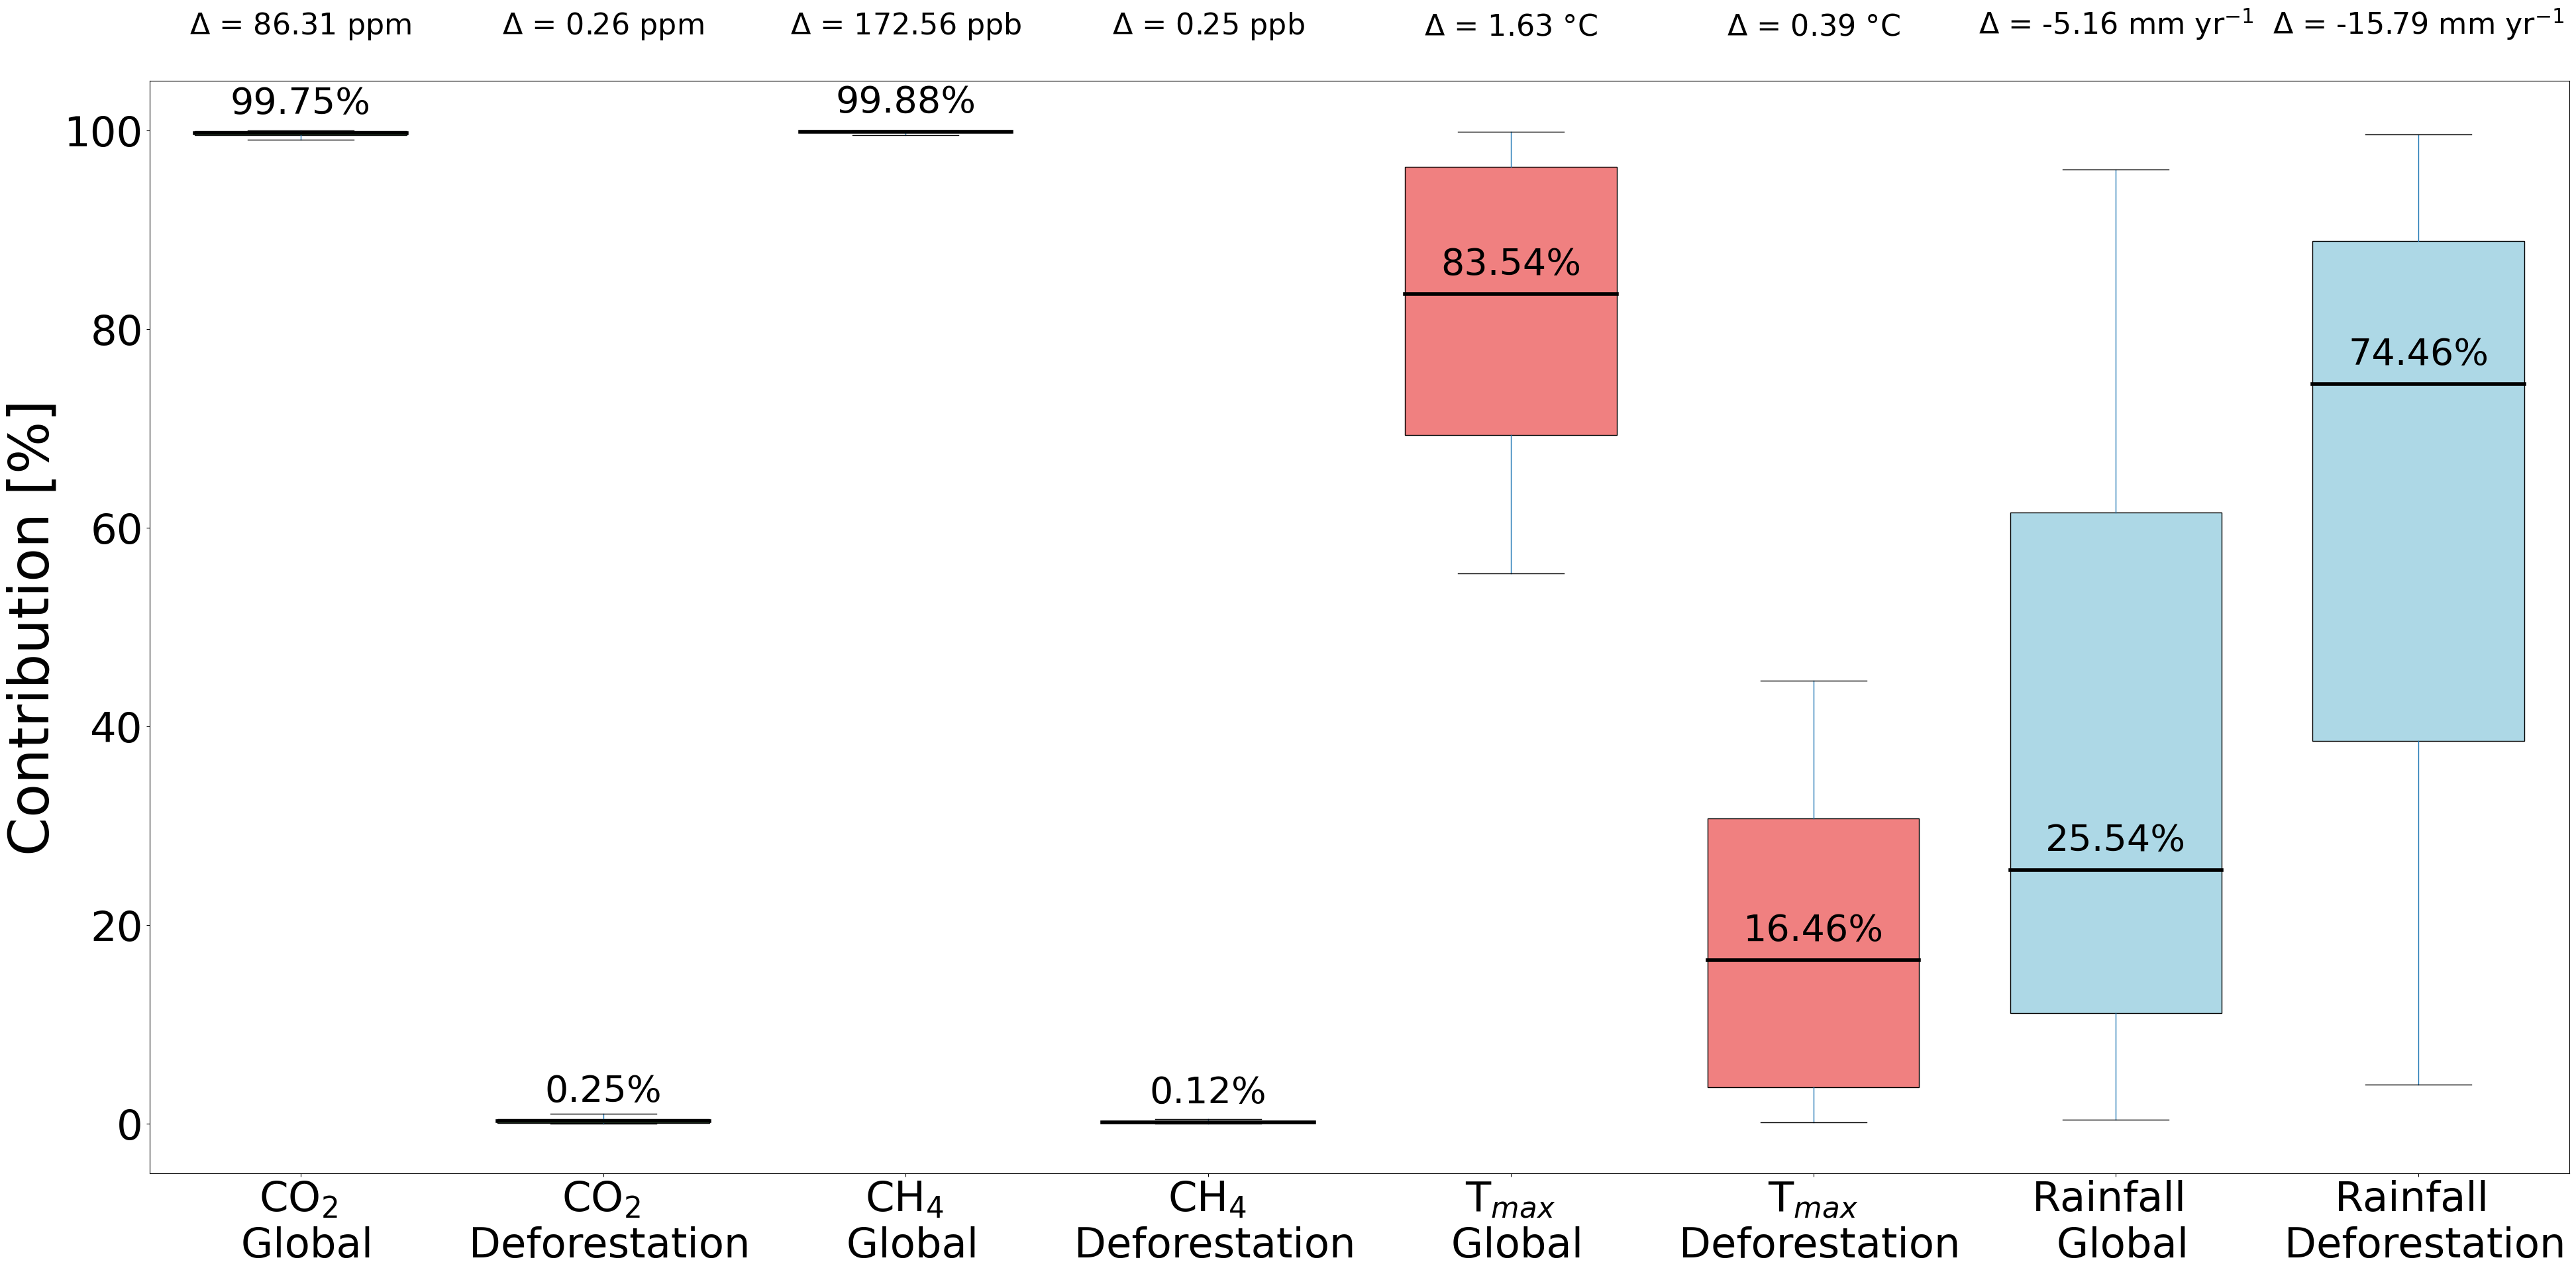

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Main directory
path = '/Dados_Figura_boxplot/'
arquivos = os.listdir(path)

# Filter only CSV files
arquivos_csv = [arquivo for arquivo in arquivos if arquivo.endswith('.csv')]
arquivos_csv = sorted(arquivos_csv)

# Assume that 'arquivos_csv' is the list of CSV filenames and 'path' is the path to the files

# Create a figure and a single subplot
plt.figure(figsize=(40, 20))
ax = plt.gca()

# Set the width of the boxplots
boxplot_width = 0.7

# Define a list of colors for the boxplots
colors = ['lightgreen', 'lightgrey', 'lightcoral', 'lightblue']

# Iterate over the CSV files
for i, arquivo_csv in enumerate(arquivos_csv):
    caminho_arquivo = os.path.join(path, arquivo_csv)
    df = pd.read_csv(caminho_arquivo)

    # Plot the boxplot in the subplot with the corresponding color
    df.boxplot(column=['Percent_Glob', 'Percent_Loc'], ax=ax, positions=[i*2, i*2+1],
               widths=[boxplot_width, boxplot_width], patch_artist=True,
               boxprops=dict(facecolor=colors[i]), medianprops = dict(color='black', linewidth=4))

    # Add the median value of Percent_Glob and Percent_Loc above each boxplot
    median_glob = df['Percent_Glob'].median()
    median_loc = df['Percent_Loc'].median()
    plt.text(i*2, median_glob + 2, f'{median_glob:.2f}%', ha='center', fontsize=40, color='black')
    plt.text(i*2 + 1, median_loc + 2, f'{median_loc:.2f}%', ha='center', fontsize=40, color='black')

    # Format the total contributions (Delta) to display above each boxplot
    var1 = ''
    var2 = ''
    if i == 0:
        var1 = '$\Delta$ = '+ str(round(df['totGlob'].mean(),2)) + ' ppm'
        var2 = '$\Delta$ = '+ str(round(df['totLoc'].mean(),2)) + ' ppm'
    if i == 1:
        var1 = '$\Delta$ = '+ str(round(df['totGlob'].mean(),2)) + ' ppb'
        var2 = '$\Delta$ = '+ str(round(df['totLoc'].mean(),2)) + ' ppb'
    if i == 2:
        var1 = '$\Delta$ = '+ str(round(df['totGlob'].mean(),2)) + ' °C'
        var2 = '$\Delta$ = '+ str(round(df['totLoc'].mean(),2)) + ' °C'
    if i == 3:
        var1 = '$\Delta$ = '+ str(round(df['totGlob'].mean(),2)) + ' mm yr$^{-1}$'
        var2 = '$\Delta$ = '+ str(round(df['totLoc'].mean(),2)) + ' mm yr$^{-1}$'

    plt.text(i*2, 109, var1, ha='center', va='bottom', fontsize=32)
    plt.text(i*2+1, 109, var2, ha='center', va='bottom', fontsize=32)

# Set x-axis tick labels
ax.set_xticklabels(['CO$_2$ \n Global','CO$_2$ \n Deforestation','CH$_{4}$ \n Global','CH$_{4}$ \n Deforestation',
                    'T$_{max}$ \n Global','T$_{max}$\n Deforestation','Rainfall \n Global','Rainfall \n Deforestation'], rotation=0, ha='center')

# Increase font size of tick labels
ax.tick_params(axis='x', labelsize=45)  # Adjust x-axis font size
ax.tick_params(axis='y', labelsize=45)  # Adjust y-axis font size

# Set y-axis label
plt.ylabel('Contribution [%]', fontsize=60)

# Optionally, add a legend with colored labels (currently commented out)
# legend_handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[i], markersize=10, label=arquivo_csv) for i, arquivo_csv in enumerate(arquivos_csv)]
# ax.legend(handles=legend_handles, loc='upper left', fontsize=12)

# Adjust layout and show plot
plt.tight_layout()
ax.grid(False)
os.chdir('G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Documentos/Preparacao_Artigo/')
# plt.savefig('Figure5_V2.png', dpi=300, bbox_inches='tight', format='png')

plt.show()
